In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('input20', 'r') as f:
    lines = [l.strip() for l in f.readlines()]

## Part 1

In [3]:
tile_size = 10

In [4]:
tile_ids = []
for line in lines:
    if line.startswith('Tile '):
        tile_ids.append(int(line.split()[1][:-1]))

tiles = np.zeros((len(tile_ids), tile_size, tile_size), dtype='int')
cur_tile = 0
r = 0
for line in lines:
    if len(line) == 0:
        cur_tile += 1
        r = 0
        continue
    if line.startswith('Tile '):
        continue
    tiles[cur_tile, r, :] = [int(v == '#') for v in line]
    r += 1

In [5]:
def get_tile_orientations(tile):
    return [
        tile,
        np.rot90(tile),
        np.rot90(tile, 2),
        np.rot90(tile, 3),
        np.fliplr(tile),
        np.rot90(np.fliplr(tile)),
        np.rot90(np.fliplr(tile), 2),
        np.rot90(np.fliplr(tile), 3),
    ]

In [6]:
def find_connections(tile, all_tiles, tile_index):
    connections = {
        't': [],
        'b': [],
        'l': [],
        'r': []
    }
    for t in range(all_tiles.shape[0]):
        for o in range(all_tiles.shape[1]):
            if t == tile_index:
                continue
            other = all_tiles[t,o,:,:]
            if (tile[:,0] == other[:,-1]).all():
                connections['l'].append((t, o))
            if (tile[:,-1] == other[:,0]).all():
                connections['r'].append((t, o))
            if (tile[0,:] == other[-1,:]).all():
                connections['t'].append((t, o))
            if (tile[-1,:] == other[0,:]).all():
                connections['b'].append((t, o))
    return connections

In [7]:
all_tiles = np.zeros((len(tile_ids), 8, tile_size, tile_size))
for t in range(len(tile_ids)):
    tile = tiles[t,:,:]
    for i, tile_orientation in enumerate(get_tile_orientations(tile)):
        all_tiles[t, i, :, :] = tile_orientation

In [8]:
connections = {}
for t in range(all_tiles.shape[0]):
    for o in range(all_tiles.shape[1]):
        tile = all_tiles[t,o,:,:]
        connections[(t, o)] = find_connections(tile, all_tiles, t)

In [9]:
corners = []
for t in range(all_tiles.shape[0]):
    for o in range(all_tiles.shape[1]):
        c = connections[(t, o)]
        if len(c['r']) > 0 and len(c['b']) > 0 and len(c['t']) == 0 and len(c['l']) == 0:
            corners.append((t, o))
print(math.prod([tile_ids[t] for t in set(t for t, _ in corners)]))

17148689442341


## Part 2

In [10]:
image_size = int(math.sqrt(len(tile_ids)))
image_indices = np.ones((image_size, image_size, 2), dtype='int') * -1
image_indices[0,0,:] = corners[1]

In [11]:
to_fill = []
for r in range(image_size):
    for c in range(image_size):
        if r == 0 and c == 0:
            continue
        to_fill.append((r, c))
for r, c in to_fill:
    available_tiles = set(range(len(tile_ids))) - set(image_indices[:,:,0].flatten())
    filled_neighbours = []
    if r > 0 and image_indices[r - 1, c, 0] != -1:
        filled_neighbours.append((r - 1, c, 'b'))
    if r < image_size - 1 and image_indices[r + 1, c, 0] != -1:
        filled_neighbours.append((r + 1, c, 't'))
    if c > 0 and image_indices[r, c - 1, 0] != -1:
        filled_neighbours.append((r, c - 1, 'r'))
    if c < image_size - 1 and image_indices[r, c + 1, 0] != -1:
        filled_neighbours.append((r, c + 1, 'l'))
    candidates = []
    for nr, nc, d in filled_neighbours:
        can = [(t, o) for t, o in connections[tuple(image_indices[nr,nc])][d] if t in available_tiles]
        candidates.extend(can)
    candidates = list(set(candidates))
    if len(candidates) == 1:
        image_indices[r,c,0] = candidates[0][0]
        image_indices[r,c,1] = candidates[0][1]
    else:
        print(f'Multiple options for {r},{c}: {candidates}')
        break

In [12]:
for r in range(3):
    for c in range(3):
        print(tile_ids[image_indices[r,c,0]], end=' ')
    print()

3181 1571 3833 
2609 1987 2447 
2297 2803 2647 


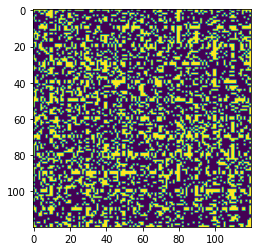

In [13]:
full_image = np.zeros((image_size * tile_size, image_size * tile_size))
for r in range(image_size):
    for c in range(image_size):
        t, o = image_indices[r,c,:]
        if t != -1:
            full_image[r * tile_size:(r + 1) * tile_size, c * tile_size:(c + 1) * tile_size] = all_tiles[t,o,:,:]

# for r in range(full_image.shape[0]):
#     for c in range(full_image.shape[1]):
#         print('#' if full_image[r,c] == 1 else '.', end='')
#         if c % tile_size == tile_size = 1:
#             print(' ', end='')
#     print()
#     if r % tile_size == tile_size - 1:
#         print()
plt.imshow(full_image);

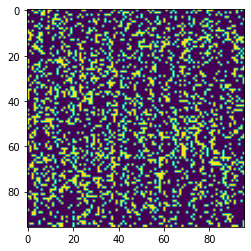

In [14]:
border_indices = sorted(
    list(range(full_image.shape[0]))[0::tile_size] +
    list(range(full_image.shape[0]))[tile_size-1::tile_size]
)
non_border_indices = list(set(range(full_image.shape[0])) - set(border_indices))
final_image = full_image[non_border_indices,:][:,non_border_indices]
plt.imshow(final_image);

In [15]:
monster_str = '''
                  # 
#    ##    ##    ###
 #  #  #  #  #  #   
'''
monster_list = []
for line in monster_str.splitlines():
    if len(line) == 0:
        continue
    monster_list.append([0 if c == ' ' else 1 for c in line])
monster_mask = np.array(monster_list)

2009


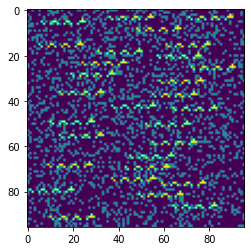

In [16]:
for im in get_tile_orientations(final_image):
    num_monsters = 0
    r = 0
    while r <= final_image.shape[0] - monster_mask.shape[0]:
        c = 0
        while c <= final_image.shape[1] - monster_mask.shape[1]:
            overlap = im[r:r + monster_mask.shape[0], c:c + monster_mask.shape[1]].astype('int')
            if overlap[monster_mask.astype('bool')].all():
                num_monsters += 1
                for mr in range(monster_mask.shape[0]):
                    for mc in range(monster_mask.shape[1]):
                        if monster_mask[mr, mc] == 1:
                            im[r + mr, c + mc] = 2
            c += 1
        r += 1
    if num_monsters > 0:
        break
print((im == 1).sum())
plt.imshow(im);